In [14]:
import numpy as np
import pandas as pd
import seaborn as sns
import statistics as stats
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
import io # StringIO
import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

In [3]:
df_bin = pd.read_csv("binary.csv")

In [4]:
df_bin['label'] = df_bin[' Label'].apply(lambda l : 0 if l == 'BENIGN' else 1)

In [5]:
X = df_bin.iloc[:, :-2]
y = df_bin['label']

In [6]:
X_train0, X_test, y_train0, y_test = train_test_split(X, y, test_size = 0.2, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train0, y_train0, test_size = 0.125, stratify=y_train0, random_state=42)

In [7]:
X_tr = np.reshape(X_train.to_numpy(), (len(X_train), 1, 80))
X_vl = np.reshape(X_val.to_numpy(), (len(X_val), 1, 80))
X_tst = np.reshape(X_test.to_numpy(), (len(X_test), 1, 80))

In [ ]:
print(X_tr.shape)
print(y_train.shape)

In [9]:
normalizer = keras.layers.Normalization()
normalizer.adapt(X_train)

inputs = keras.Input(shape=(1, 80))

x = normalizer(inputs)

x = LSTM(512, activation='tanh', return_sequences=True)(x)
x = LSTM(128, activation='tanh')(x)
outputs = Dense(1, activation='sigmoid')(x)

model = keras.Model(inputs=inputs, outputs=outputs, name='LSTM_model')
model.compile(optimizer="Adam", loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "LSTM_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1, 80)]           0         
                                                                 
 normalization (Normalizatio  (None, 1, 80)            161       
 n)                                                              
                                                                 
 lstm (LSTM)                 (None, 1, 512)            1214464   
                                                                 
 lstm_1 (LSTM)               (None, 128)               328192    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,542,946
Trainable params: 1,542,785
Non-trainable params: 161
____________________________________________

In [12]:
history=model.fit(X_tr, y_train.to_numpy(), validation_data = (X_vl, y_val.to_numpy()), batch_size=len(X_tr), epochs=10)

Epoch 1/10
1/1 [==============================] - 23s 23s/step - loss: 0.6929 - accuracy: 0.5361 - val_loss: 0.6684 - val_accuracy: 0.9634
Epoch 2/10
1/1 [==============================] - 21s 21s/step - loss: 0.6684 - accuracy: 0.9632 - val_loss: 0.6443 - val_accuracy: 0.9644
Epoch 3/10
1/1 [==============================] - 15s 15s/step - loss: 0.6440 - accuracy: 0.9639 - val_loss: 0.6192 - val_accuracy: 0.9643
Epoch 4/10
1/1 [==============================] - 15s 15s/step - loss: 0.6189 - accuracy: 0.9639 - val_loss: 0.5929 - val_accuracy: 0.9655
Epoch 5/10
1/1 [==============================] - 16s 16s/step - loss: 0.5924 - accuracy: 0.9652 - val_loss: 0.5650 - val_accuracy: 0.9651
Epoch 6/10
1/1 [==============================] - 15s 15s/step - loss: 0.5645 - accuracy: 0.9650 - val_loss: 0.5359 - val_accuracy: 0.9650
Epoch 7/10
1/1 [==============================] - 16s 16s/step - loss: 0.5353 - accuracy: 0.9648 - val_loss: 0.5057 - val_accuracy: 0.9649
Epoch 8/10
1/1 [===========

In [13]:
#history=model.fit(X_tr, y_train.to_numpy(), batch_size=len(X_tr), epochs=10)
path_new_model = "/content/LSTM_binary.h5"

#Save final model
#model.save(path_new_model)

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


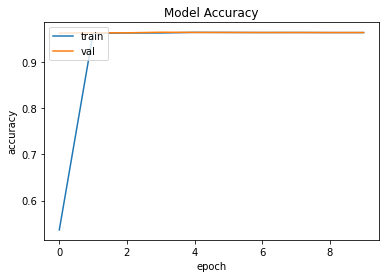

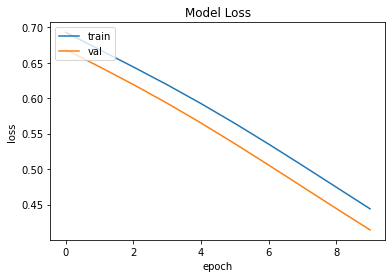

In [15]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('/content/LSTM_binary_train.png')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('/content/LSTM_binary_val.png')
plt.show()

In [17]:
#Test metrics
test_loss, test_acc = model.evaluate(X_tst, y_test, verbose=0)
print('Test metrics: Loss {0} Accuracy: {1}'.format(test_loss,test_acc))

#Test predictions
prediction = model.predict(X_tst)

Test metrics: Loss 0.41265249252319336 Accuracy: 0.9638554453849792
683/683 [==============================] - 6s 7ms/step


In [ ]:
pred = [1 if prediction[i] >= 0.5 else 0 for i in range(len(prediction))]
#pd.Series(pred).value_counts()

[[10844    71]
 [  718 10196]]


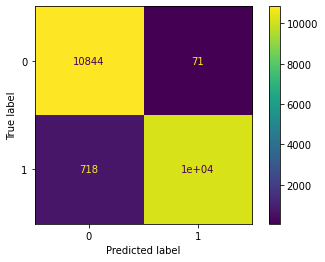

In [28]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.savefig('/content/LSTM_binary_test_ConfusionMatrix.png')
print(cm)
plt.show()